# Notebook Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path += ["../"]

In [3]:
import warnings
warnings.filterwarnings("ignore")

Note that we are using the local ds_nudge_up repo only for loading the utils.
The rest is done using the pip installed library.

In [4]:
import os
import src.mosaiks.utils as utl
rasterio_config = utl.load_yaml_config("rasterioc_config.yaml")
os.environ.update(rasterio_config)

In [5]:
os.getcwd()

'/home/jovyan/ds_nudge_up/playground'

In [6]:
!pip install -e ..

Obtaining file:///home/jovyan/ds_nudge_up
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mosaiks (pyproject.toml) ... done
  Created wheel for mosaiks: filename=mosaiks-0.0.1rc0-0.editable-py3-none-any.whl size=2238 sha256=68bc0263678e56ebef9fec5ed3204bfcf4b4f21295e7055d0ab8832a998ef91f
  Stored in directory: /tmp/pip-ephem-wheel-cache-yzs8uadj/wheels/b9/af/5e/752b683d2cb159d37a03ef74be9f004303ccd51e4ee80d1e9c
Successfully built mosaiks
  Attempting uninstall: mosaiks
    Found existing installation: mosaiks 0.0.1rc0
    Uninstalling mosaiks-0.0.1rc0:
      Successfully uninstalled mosaiks-0.0.1rc0


In [7]:
# !pip uninstall mosaiks -y

🚨🚨 **Make sure you update github token in the secrets file** 🚨🚨 

In [8]:
# secrets = utl.load_yaml_config("../config/secrets.yml")
# GITHUB_TOKEN = secrets["GITHUB_TOKEN"]
# mosaiks_package_link = f"git+https://{GITHUB_TOKEN}@github.com/IDinsight/ds_nudge_up@as-package"

In [9]:
# !pip install {mosaiks_package_link} --upgrade

# Setup Dask Cluster and Client

## Local Cluster

4 workers with 4 threads each seem to work best. A lot of time a thread is waiting on data to load so CPU is underutilized.

In [10]:
import logging
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=4, processes=True, threads_per_worker=4, silence_logs=logging.ERROR)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/amirali1376@gmail.com/proxy/8787/status,
Dashboard: /user/amirali1376@gmail.com/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 27.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43963,Workers: 4
Dashboard: /user/amirali1376@gmail.com/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 27.00 GiB
Comm: tcp://127.0.0.1:45357,Total threads: 4
Dashboard: /user/amirali1376@gmail.com/proxy/38645/status,Memory: 6.75 GiB
Nanny: tcp://127.0.0.1:36073,


## Gateway cluster

In [11]:
# from dask_gateway import Gateway
# import dask_gateway
# from dask.distributed import PipInstall

# gateway = Gateway()
# options = gateway.cluster_options()
# options

In [12]:
# from dask.distributed import PipInstall

# cluster = gateway.new_cluster(options)
# client = cluster.get_client()
# print(cluster.dashboard_link)

# plugin = PipInstall(packages=[mosaiks_package_link], pip_options=["--upgrade"], restart=False)
# client.register_worker_plugin(plugin)

# cluster.scale(10)

In [13]:
# cluster.shutdown()

# Load params

In [14]:
from mosaiks.featurize import *

from dask import delayed
from dask.distributed import as_completed
from time import sleep
import pandas as pd
import numpy as np

In [15]:
featurization_params = utl.load_yaml_config("featurisation.yaml")
satellite_config = utl.load_yaml_config("satellite_config.yaml")
satellite_config = satellite_config[featurization_params['satellite_search_params']['satellite_name']]
data_sources = utl.load_yaml_config('data_catalog.yaml')

# Load point coords

In [16]:
# centroid_points_gdf = utl.load_points_gdf(**data_sources['request_points_centroids'])

# # only keep points in the focus states
# focus_states_id_dict = {
#     20:"jharkhand",
#     22:"chhattisgarh",
#     8:"rajasthan",
#     23:"madhya pradesh",
#     18:"assam",
#     16:"tripura",
# }

# focus_states_filter = centroid_points_gdf["pc11_s_id"].isin(focus_states_id_dict.keys())
# points_gdf_focus = centroid_points_gdf[focus_states_filter]
# points_gdf_focus.shape

# points_gdf = points_gdf_focus  #.sample(200, random_state=0) # Select random 200 points (for testing)

In [17]:
points_gdf = utl.load_points_gdf(**data_sources['request_points_centroids'])

# Fetch image stac refs

`fetch_image_refs` now returns a dask dataframe and is not yet computed. So it finishes quite quickly.

🌱 **SUGGESTION:** Change `n_partitions` parameter to `n_per_partition` and calculate `n_partitions` here? This will ensure each partition takes a similar amount of time to process even across differing point-set sizes.

In [18]:
%%time
points_gdf_with_stac = fetch_image_refs(
    points_gdf, 
    featurization_params['dask']['n_partitions'],
    featurization_params['satellite_search_params']
)

CPU times: user 7.86 s, sys: 776 ms, total: 8.64 s
Wall time: 27.5 s


# Define delayed objects

We use the `delayed` decorator to turn our function into a delayed function. This means it will not run immediately when called but instead return a delayed object that can be run later

In [19]:
@delayed
def partition_run(df, satellite_config, featurization_params, model, device):
    
    data_loader = create_data_loader(df, satellite_config, featurization_params['batch_size'])
    X_features = create_features(
        data_loader, 
        featurization_params['num_features'], 
        len(df), 
        model, 
        device, 
        satellite_config['min_image_edge']
    )
    
    df = pd.DataFrame(X_features, index=df.index.copy())
    
    return df

We want to convert our dask dataframe into "delayed" objects. Each partition is now a delayed pandas dataframe and can be passed to our delayed function above

In [20]:
partitions = points_gdf_with_stac.to_delayed()

In [21]:
model = RCF(featurization_params['num_features'], 
            featurization_params['kernel_size'], 
            len(satellite_config['bands']))

Batch size of 10 seems to be optimal balance between maximally using the CPU and not blowing up the memory

In [22]:
featurization_params['batch_size']

10

# Run in parallel

## Trial run

The cell below will only run it for 8 of the partitions. That seems to be about how many we can do in parallel on a local cluster. We may be able to do more on a Gateway Cluster once that is working.

There are also better schemes. For example, kick off another partitions whenever one finishes. That might be a better use of resources.

In [23]:
%%time

dfs = []
for i, p in enumerate(partitions[:1]):
    f = partition_run(p, satellite_config, featurization_params, model, 'cuda', dask_key_name=f'run_{i}')
    dfs.append(f)
dfs = client.compute(dfs, )

df_list = []
for f in as_completed(dfs[:2]):
    df_list.append(f.result())

CPU times: user 1min 36s, sys: 21.8 s, total: 1min 58s
Wall time: 7min 56s


In [24]:
df_list[0]

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
623652,0.0,1.743787,0.0,0.0,2.884346,0.000110,1.770842,0.000000,0.084646,1.261963,...,3.121850,0.261250,2.056214,0.000895,5.877407,2.139980,0.013218,2.082803,1.143130,0.000000
623661,0.0,0.844259,0.0,0.0,1.238577,0.001782,0.523993,0.000000,0.019060,0.692979,...,2.422239,0.799767,1.700916,0.102297,4.034412,1.804642,0.000000,1.767805,1.750991,0.000000
623662,0.0,0.852489,0.0,0.0,1.689520,0.001054,0.578646,0.000000,0.074234,0.330670,...,2.646355,0.575597,1.625605,0.000555,4.306748,2.207318,0.000599,2.095250,1.169220,0.000000
623656,0.0,1.505864,0.0,0.0,2.535293,0.001951,0.883273,0.000000,0.097106,0.690966,...,2.753911,1.236984,1.522913,0.066520,4.954687,3.066687,0.000000,2.606335,1.318218,0.000000
623660,0.0,1.187283,0.0,0.0,2.062685,0.002156,0.685949,0.000000,0.049573,0.548838,...,2.275028,1.528296,1.304119,0.240880,4.379772,2.920174,0.000000,2.420344,1.349473,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614412,0.0,0.977472,0.0,0.0,0.902752,0.000057,0.777393,0.000161,0.023812,1.625078,...,3.907075,0.000000,2.899287,0.000000,5.065322,0.648902,0.031024,1.807150,3.853646,0.000118
614413,0.0,1.314524,0.0,0.0,1.197196,0.000988,1.079925,0.000184,0.035115,2.097835,...,4.365802,0.000000,3.228405,0.000000,5.754263,0.569248,0.029427,1.896221,4.346093,0.000011
614377,0.0,0.794881,0.0,0.0,0.789399,0.000231,0.584897,0.000000,0.063254,1.241639,...,3.624172,0.005294,2.647934,0.001475,4.607974,0.803947,0.121337,1.804333,3.414632,0.017684
614366,0.0,0.826406,0.0,0.0,0.622652,0.000000,0.628063,0.000003,0.009908,1.502084,...,3.542678,0.000000,2.747881,0.000000,4.693815,0.576313,0.053121,1.614317,3.754932,0.000953


In [25]:
df_list[0].mean().mean()

0.9609073540960744

<AxesSubplot:>

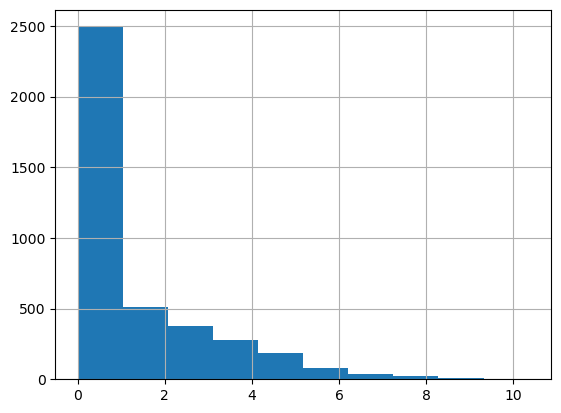

In [26]:
df_list[0].iloc[0].hist()

With 100k points and 200 partitions, 8 partitions should take ~7-8 minutes on an MPC GPU instance. So that's <1 minute per partition. If nothing goes wrong, the whole job should finish in <4 hours.

In theory, objects should get garbage collected once there are no references to them. But it seems to take forever (or never!) for python to do that. Possibly since we have a lot of nested things and a model object that we are still holding a reference to.

Restarting the cluster seems to be the sure way of clearing worker memory.

In [27]:
_ = client.restart()

## Full run

This is going to create 200 dataframes - one for each partition. If any fail, we can always just rerun that single component.

In [28]:
from datetime import datetime

In [29]:
N_PARTITIONS = len(partitions)
N_PER_RUN = 8
START_IDX = 0
str_column_names = [str(i) for i in range(featurization_params['num_features'])]

folder_name = "L8_2013_centroid_focus_states_uint16_normed_dask"
path_to_folder = "../data/01_preprocessed/mosaiks_features/"+folder_name
if not os.path.exists(path_to_folder):
    os.makedirs(path_to_folder)

In [30]:
p_ids = np.arange(START_IDX, N_PARTITIONS + N_PER_RUN, N_PER_RUN)

failed_list = []
for p_start_id, p_end_id in zip(p_ids[:-1], p_ids[1:]):
    now = datetime.now().strftime("%d-%b %H:%M:%S")
    print(f"{now} Running batch: ", p_start_id, "to", p_end_id-1)
    
    delayed_dfs = []
    for i, p in enumerate(partitions[p_start_id:p_end_id]):
        f = partition_run(
            p, 
            satellite_config, 
            featurization_params, 
            model, 
            featurization_params['device'], 
            dask_key_name=f'features_{p_start_id + i}'
        )
        delayed_dfs.append(f)
    futures_dfs = client.compute(delayed_dfs)
    
    for f in as_completed(futures_dfs):
        try:
            df = f.result()
            df.columns = str_column_names
            df.to_parquet(f'{path_to_folder}/df_{f.key}.parquet.gzip', compression='gzip')

        except Exception as e:
            f_key = f.key
            partition_id = int(f_key.split("features_")[1])
            print(f"Partition {partition_id} failed. Error:", e)
            failed_list.append(partition_id)
        
    client.restart()
    sleep(5)

01-Mar 06:47:14 Running batch:  0 to 7
01-Mar 07:12:31 Running batch:  8 to 15
01-Mar 07:37:04 Running batch:  16 to 23
01-Mar 08:01:54 Running batch:  24 to 31
01-Mar 08:28:28 Running batch:  32 to 39
01-Mar 08:53:50 Running batch:  40 to 47
01-Mar 09:20:32 Running batch:  48 to 55
01-Mar 09:45:28 Running batch:  56 to 63


KeyboardInterrupt: 

In [31]:
client.shutdown()

## Re-run failed partitions

Use this to just run partitions that failed

In [ ]:
%%time

FAILED_IDX = failed_list #[44]

delayed_dfs = []
failed_list_1 = []
for i in FAILED_IDX:
    p = partitions[i]
    f = partition_run(
        p, 
        satellite_config, 
        featurization_params, model, 
        featurization_params['device'], 
        dask_key_name=f'features_{i}'
    )
    delayed_dfs.append(f)
    futures_dfs = client.compute(delayed_dfs)
    
    for f in as_completed(futures_dfs):
        try:
            df = f.result()
            df.columns = str_column_names
            df.to_parquet(f'{path_to_folder}/df_{f.key}.parquet.gzip', compression='gzip')
        except Exception as e:
            print(f"Partition {f.key} failed. Error:", e)
            failed_list_1.append(f.key)

In [ ]:
# _ = client.restart()

# Load checkpoint files and combine

In [ ]:
all_files = os.listdir(path_to_folder)
parquet_files = sorted([file for file in all_files if file.endswith('.gzip')])
pd.Series(parquet_files).to_csv(f"{path_to_folder}/file_list.csv")
# parquet_files

In [ ]:
dfs = []
for filename in parquet_files:
    df = pd.read_parquet(path_to_folder+"/"+filename)
    dfs.append(df)

combined_df = pd.concat(dfs, axis=0)
combined_df.sort_index(inplace=True)

# add LatLons
combined_df = combined_df.join(points_gdf[["Lat","Lon", "shrid"]])

print("Dataset size in memory (MB):", combined_df.memory_usage().sum() / 1000000)

In [ ]:
combined_df.to_parquet(path_to_folder + "/" + folder_name + ".parquet.gzip", compression="gzip")

In [ ]:
# combined_df_deduped = combined_df.drop_duplicates(subset=["Lat", "Lon", "0"])

In [ ]:
# df = pd.read_parquet(path_to_folder+"/combined.parquet.gzip")
# df